<a href="https://colab.research.google.com/github/wj198414/ASTRON1221/blob/main/DarkEnergy/Supernovae_cosmology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import astropy.io.ascii
import astropy.units as u
import astropy.constants as ac

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Tonry_2003.vot to Tonry_2003.vot


In [4]:
dat = astropy.io.ascii.read("Tonry_2003.vot")

/usr/local/lib/python3.10/dist-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Text(0, 0.5, 'Velocity [km/s]')

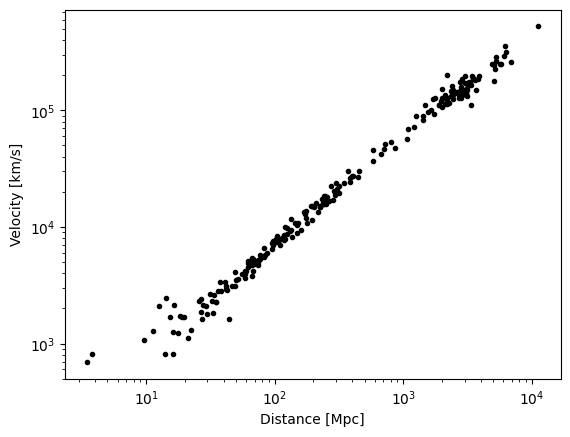

In [5]:
distance = 10**dat["col8"] / 72.0 * u.mpc
distance_error = (10**(dat["col8"]+dat["col9"]) - 10**dat["col8"]) / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.plot(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, marker=".", color="black", linestyle="none")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

Text(0, 0.5, 'Velocity [km/s]')

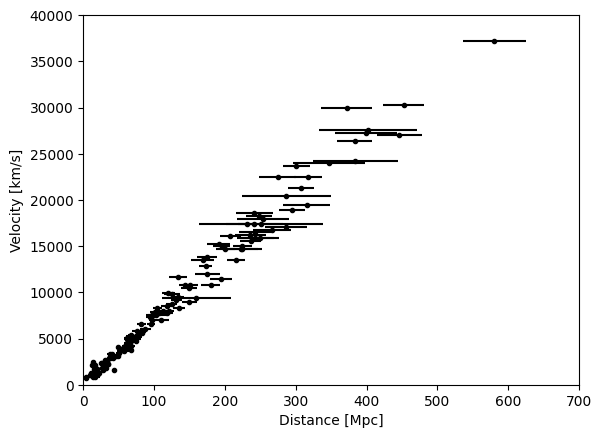

In [6]:
distance = 10**dat["col8"] / 72.0 * u.mpc
velocity = 10**dat["col7"] * u.km / u.s
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

In [7]:
x = distance.to(u.mpc).value
ind = np.where((x > 0) & (x < 700))
z = np.polyfit(distance.to(u.mpc).value[ind], velocity.to(u.km / u.s).value[ind], 1)

In [8]:
p = np.poly1d(z)

In [9]:
velocity_model = p(distance.to(u.mpc).value)

Text(50, 30000, '$H_0$ = 67.48 km/s/Mpc')

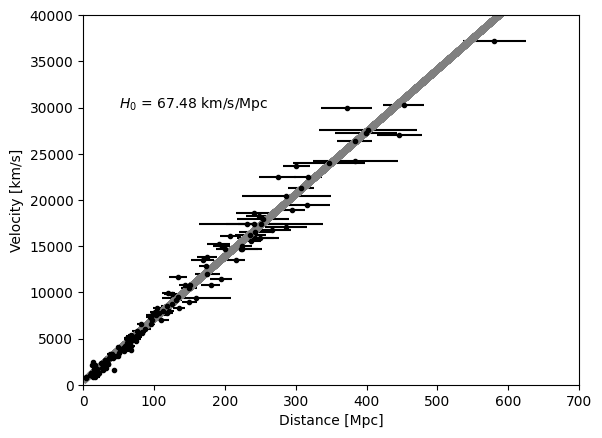

In [10]:
plt.errorbar(distance.to(u.mpc).value, velocity.to(u.km / u.s).value, xerr=distance_error.to(u.mpc).value, marker=".", color="black", linestyle="none")
plt.plot(distance.to(u.mpc).value, velocity_model, color="grey", linewidth=5)
plt.xlim(0, 700)
plt.ylim(0, 4e4)
plt.xlabel("Distance [Mpc]")
plt.ylabel("Velocity [km/s]")
plt.annotate(r"$H_0$ = {0:5.2f} km/s/Mpc".format(z[0]), xy=(50, 30000))

https://emcee.readthedocs.io/en/stable/tutorials/line/

Text(0.5, 0, 'Velocity [km/s]')

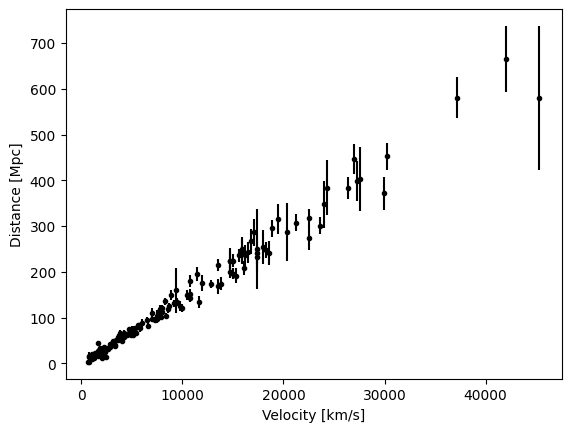

In [20]:
x = velocity.to(u.km / u.s).value[ind]
y = distance.to(u.mpc).value[ind]
yerr = distance_error.to(u.mpc).value[ind]

plt.errorbar(x, y, yerr=yerr, marker=".", color="black", linestyle="none")
# plt.ylim(0, 700)
# plt.xlim(0, 4e4)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]")


Least-squares estimates:
m = 0.015 ± 0.000
b = -6.338 ± 0.219


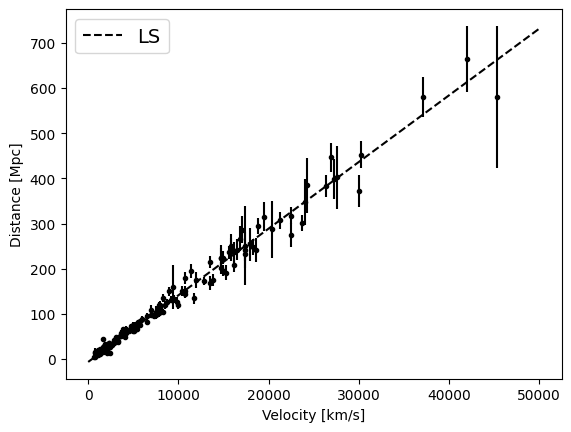

In [27]:
x0 = np.linspace(0, 50000, 500)

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [28]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
m = 0.014
b = -0.981
f = 0.167


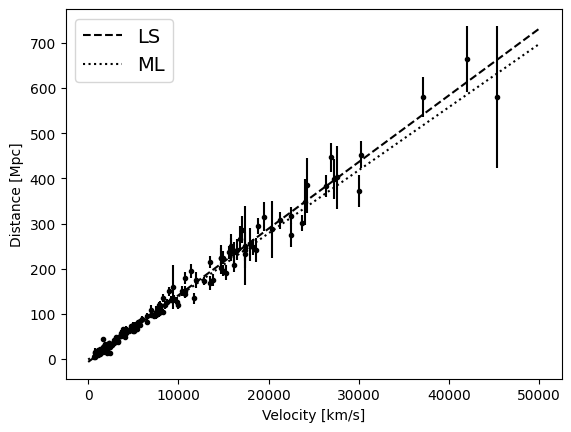

In [29]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([1 / 72.0, 0.0, np.log(1.0)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");

In [31]:
def log_prior(theta):
    m, b, log_f = theta
    if 0.0 < m < 0.5 and -100.0 < b < 100.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)




In [33]:
! pip install -U emcee


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.2 MB/s eta 0:00:00


In [34]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:19<00:00, 250.65it/s]


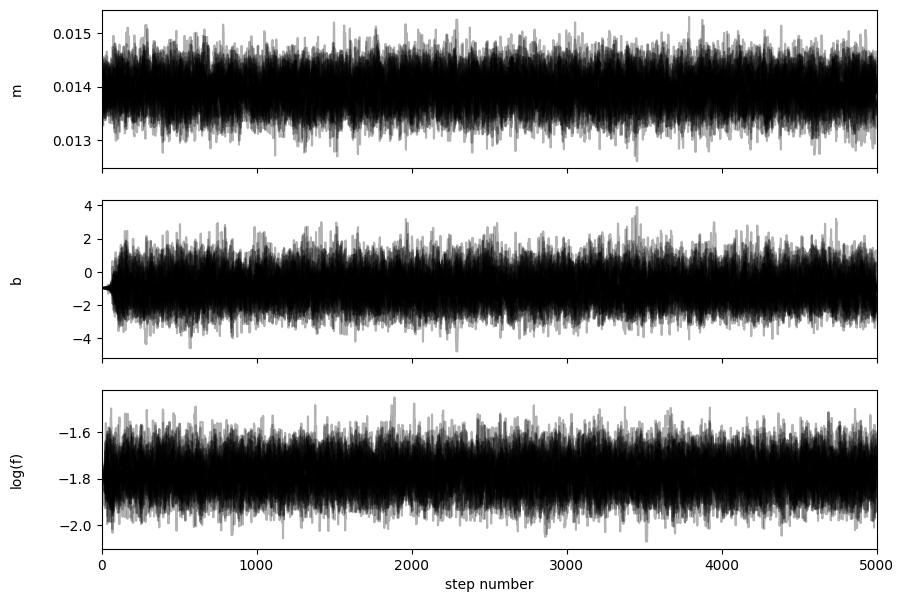

In [35]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
tau = sampler.get_autocorr_time()
print(tau)

[35.93960485 37.30467612 34.71829195]


In [37]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [39]:
! pip install corner

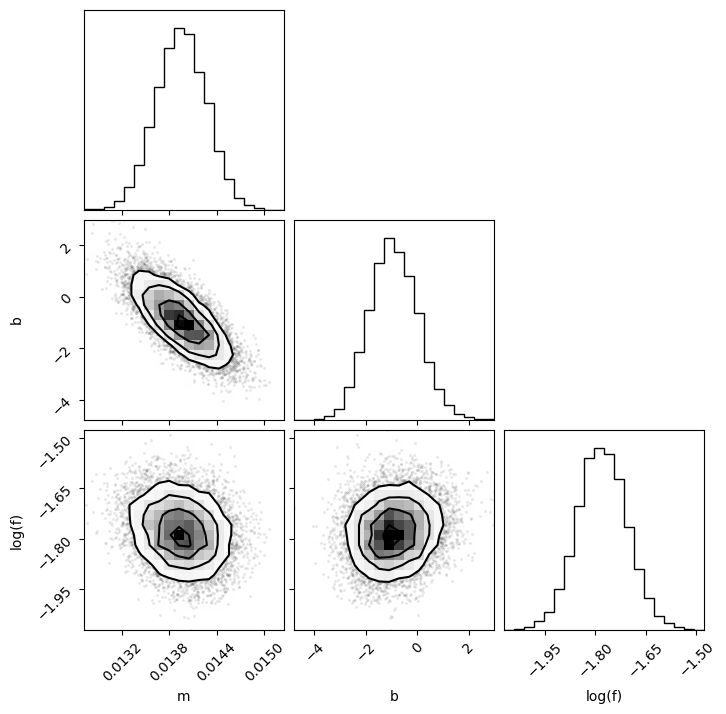

In [41]:
import corner

fig = corner.corner(flat_samples, labels=labels);


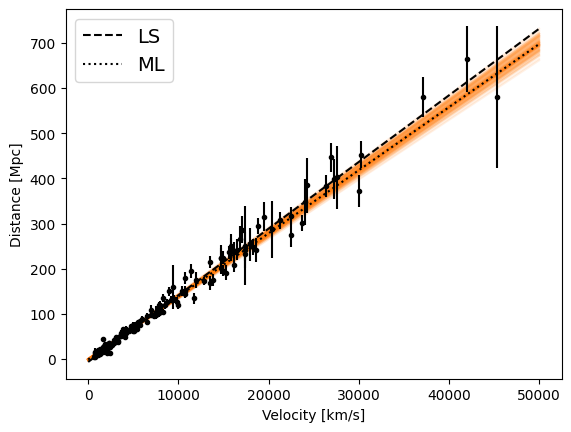

In [43]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel("Distance [Mpc]")
plt.xlabel("Velocity [km/s]");


In [45]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>